# Piezometer Landslide Prediction System

This notebook implements an advanced machine learning-based landslide prediction system using piezometer data. The system monitors groundwater pressure and level changes to predict potential landslide events.

## System Components
1. Data Collection and Management (Piezometer Readings)
2. Data Preprocessing and Feature Engineering
3. Exploratory Data Analysis
4. Model Training (Random Forest & Gradient Boosting)
5. Prediction Pipeline
6. Risk Visualization and Alerts

## Data Fields
- **timestamp**: Date and time of measurement
- **pore_pressure**: Pore water pressure (kPa)
- **groundwater_level**: Water table depth (m)
- **pressure_change_rate**: Rate of pressure change (kPa/day)
- **point_coordinates**: 3D location (x, y, z)

## 1. Setup and Required Libraries

Import necessary libraries and set up the environment for piezometer data processing and analysis.

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, r2_score, confusion_matrix, classification_report
import joblib
import warnings
import json
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create necessary directories
os.makedirs('data', exist_ok=True)
os.makedirs('data/models', exist_ok=True)

# Define file paths
DATA_FILE = 'data/piezometer_data.csv'
PREDICTIONS_FILE = 'data/piezometer_predictions.csv'
RF_MODEL_PATH = 'data/models/piezometer_rf_model.joblib'
GB_MODEL_PATH = 'data/models/piezometer_gb_model.joblib'

print("✓ Libraries imported successfully")
print("✓ Directories created")
print("✓ System initialized")

✓ Libraries imported successfully
✓ Directories created
✓ System initialized


## 2. Data Generation and Management

Create synthetic piezometer data for landslide monitoring or load existing data. The system simulates 2 readings per day with realistic pressure and groundwater patterns.

In [2]:
def generate_piezometer_data(n_samples=60):
    """
    Generate synthetic piezometer data with realistic groundwater patterns.
    Creates 2 readings per day over 30 days.
    """
    data = {
        'timestamp': [],
        'pore_pressure': [],
        'groundwater_level': [],
        'pressure_change_rate': [],
        'point_coordinates': [],
        'risk_class': []
    }
    
    # Generate timestamps (2 readings per day)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=n_samples/2)
    timestamps = []
    current_date = start_date
    while current_date <= end_date:
        timestamps.extend([current_date, current_date + timedelta(hours=12)])
        current_date += timedelta(days=1)
    timestamps = timestamps[:n_samples]
    
    # Generate synthetic piezometer measurements
    base_pressure = 50  # kPa baseline
    base_water_level = 5  # meters baseline
    
    for i in range(n_samples):
        # Simulate pressure increase over time with variation
        pressure_trend = i * 0.3  # Increasing trend
        pressure_noise = np.random.normal(0, 5)
        pore_pressure = base_pressure + pressure_trend + pressure_noise
        
        # Groundwater level (higher = shallower = more dangerous)
        water_level = base_water_level - (i * 0.05) + np.random.normal(0, 0.5)
        water_level = max(0.5, water_level)  # Keep above minimum
        
        # Pressure change rate
        if i == 0:
            pressure_rate = 0
        else:
            pressure_rate = (pore_pressure - data['pore_pressure'][-1]) / 0.5  # per day
        
        data['timestamp'].append(timestamps[i])
        data['pore_pressure'].append(pore_pressure)
        data['groundwater_level'].append(water_level)
        data['pressure_change_rate'].append(pressure_rate)
        
        # 3D coordinates (x, y, z - elevation)
        x = np.random.uniform(0, 100)
        y = np.random.uniform(0, 100)
        z = np.random.uniform(300, 500)  # Elevation in meters
        data['point_coordinates'].append(f"{x:.2f}, {y:.2f}, {z:.2f}")
        
        # Risk classification based on pressure and water level
        if pore_pressure > 65 or water_level < 2:
            risk = 'High'
        elif pore_pressure > 55 or water_level < 3.5:
            risk = 'Medium'
        else:
            risk = 'Low'
        data['risk_class'].append(risk)
    
    return pd.DataFrame(data)

def load_or_create_piezometer_data():
    """
    Load existing piezometer data or create new synthetic data if file doesn't exist.
    """
    if os.path.exists(DATA_FILE):
        existing_data = pd.read_csv(DATA_FILE)
        existing_data['timestamp'] = pd.to_datetime(existing_data['timestamp'])
        print(f"✓ Loaded existing data: {len(existing_data)} records")
        return existing_data
    else:
        new_data = generate_piezometer_data()
        new_data.to_csv(DATA_FILE, index=False)
        print(f"✓ Generated new data: {len(new_data)} records")
        return new_data

# Load or generate initial data
df = load_or_create_piezometer_data()
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nData columns: {df.columns.tolist()}")
df.head()

✓ Generated new data: 60 records

Dataset shape: (60, 6)
Date range: 2025-09-18 10:51:10.920603 to 2025-10-17 22:51:10.920603

Data columns: ['timestamp', 'pore_pressure', 'groundwater_level', 'pressure_change_rate', 'point_coordinates', 'risk_class']


,timestamp,pore_pressure,groundwater_level,pressure_change_rate,point_coordinates,risk_class
0,2025-09-18 10:51:10.920603,52.483571,4.930868,0.000000,"73.20, 59.87, 331.20",Low
1,2025-09-18 22:51:10.920603,51.695206,5.455258,-1.576729,"70.81, 2.06, 493.98",Low
2,2025-09-19 10:51:10.920603,48.252628,5.171280,-6.885157,"18.18, 18.34, 360.85",Low
3,2025-09-19 22:51:10.920603,37.837255,5.325185,-20.830746,"29.12, 61.19, 327.90",Low
4,2025-09-20 10:51:10.920603,46.659880,4.093848,17.645249,"45.61, 78.52, 339.93",Low


## 3. Data Preprocessing and Feature Engineering

Prepare the data for analysis by handling missing values, scaling numerical features, and creating derived features.

In [3]:
def preprocess_piezometer_data(df):
    """
    Preprocess piezometer data and engineer new features.
    """
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Handle missing values
    numeric_columns = ['pore_pressure', 'groundwater_level', 'pressure_change_rate']
    processed_df[numeric_columns] = processed_df[numeric_columns].fillna(processed_df[numeric_columns].mean())
    
    # Feature engineering
    # 1. Pressure-water level ratio (higher = more risk)
    processed_df['pressure_water_ratio'] = processed_df['pore_pressure'] / (processed_df['groundwater_level'] + 1e-6)
    
    # 2. Cumulative pressure change
    processed_df['cumulative_pressure_change'] = processed_df['pore_pressure'].diff().fillna(0).cumsum()
    
    # 3. Pressure acceleration (rate of rate change)
    processed_df['pressure_acceleration'] = processed_df['pressure_change_rate'].diff().fillna(0)
    
    # 4. Water level change rate
    processed_df['water_level_change_rate'] = processed_df['groundwater_level'].diff().fillna(0)
    
    # 5. Critical zone indicator (high pressure + shallow water)
    processed_df['critical_zone'] = ((processed_df['pore_pressure'] > 60) & 
                                     (processed_df['groundwater_level'] < 3)).astype(int)
    
    # Extract coordinates for analysis
    coords = processed_df['point_coordinates'].str.split(',', expand=True)
    processed_df['coord_x'] = coords[0].astype(float)
    processed_df['coord_y'] = coords[1].astype(float)
    processed_df['coord_z'] = coords[2].astype(float)
    
    # Replace inf values
    processed_df.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Create binary target for landslide occurrence (High risk = 1, others = 0)
    processed_df['landslide_likely'] = (processed_df['risk_class'] == 'High').astype(int)
    
    # Calculate days until potential event (for regression)
    processed_df['days_until_event'] = processed_df.apply(
        lambda row: 1 if row['risk_class'] == 'High' 
        else 3 if row['risk_class'] == 'Medium'
        else 7, axis=1
    )
    
    # Scale numerical features
    scaler = StandardScaler()
    numeric_features = numeric_columns + ['pressure_water_ratio', 'cumulative_pressure_change', 
                                         'pressure_acceleration', 'water_level_change_rate',
                                         'coord_x', 'coord_y', 'coord_z']
    processed_df[numeric_features] = scaler.fit_transform(processed_df[numeric_features])
    
    return processed_df, scaler

# Process the data
processed_df, scaler = preprocess_piezometer_data(df)
print("✓ Data preprocessing completed")
print(f"\nProcessed features: {len(processed_df.columns)} columns")
print(f"Engineered features: pressure_water_ratio, cumulative_pressure_change, pressure_acceleration, water_level_change_rate, critical_zone")
print(f"\nRisk distribution:")
print(processed_df['risk_class'].value_counts())
processed_df.head()

✓ Data preprocessing completed

Processed features: 16 columns
Engineered features: pressure_water_ratio, cumulative_pressure_change, pressure_acceleration, water_level_change_rate, critical_zone

Risk distribution:
risk_class
Medium    30
Low       16
High      14
Name: count, dtype: int64


,timestamp,pore_pressure,groundwater_level,pressure_change_rate,point_coordinates,risk_class,pressure_water_ratio,cumulative_pressure_change,pressure_acceleration,water_level_change_rate,critical_zone,coord_x,coord_y,coord_z,landslide_likely,days_until_event
0,2025-09-18 10:51:10.920603,-0.815759,1.427109,-0.037970,"73.20, 59.87, 331.20",Low,-1.062717,-0.815759,0.008878,0.040690,0,0.914928,0.378312,-1.180908,0,7
1,2025-09-18 22:51:10.920603,-0.916016,2.012142,-0.142986,"70.81, 2.06, 493.98",Low,-1.240819,-0.916016,-0.054360,0.663619,0,0.832568,-1.604062,1.606793,0,7
2,2025-09-19 10:51:10.920603,-1.353810,1.695323,-0.496546,"18.18, 18.34, 360.85",Low,-1.262986,-1.353810,-0.204029,-0.296651,0,-0.981093,-1.045801,-0.673135,0,7
3,2025-09-19 22:51:10.920603,-2.678338,1.867027,-1.425371,"29.12, 61.19, 327.90",Low,-1.602446,-2.678338,-0.550442,0.223515,0,-0.604094,0.423576,-1.237423,0,7
4,2025-09-20 10:51:10.920603,-1.556361,0.493292,1.137265,"45.61, 78.52, 339.93",Low,-0.947760,-1.556361,1.552047,-1.422031,0,-0.035839,1.017843,-1.031402,0,7


## 4. Exploratory Data Analysis

Analyze patterns and relationships in the piezometer data through advanced visualizations and statistical summaries.

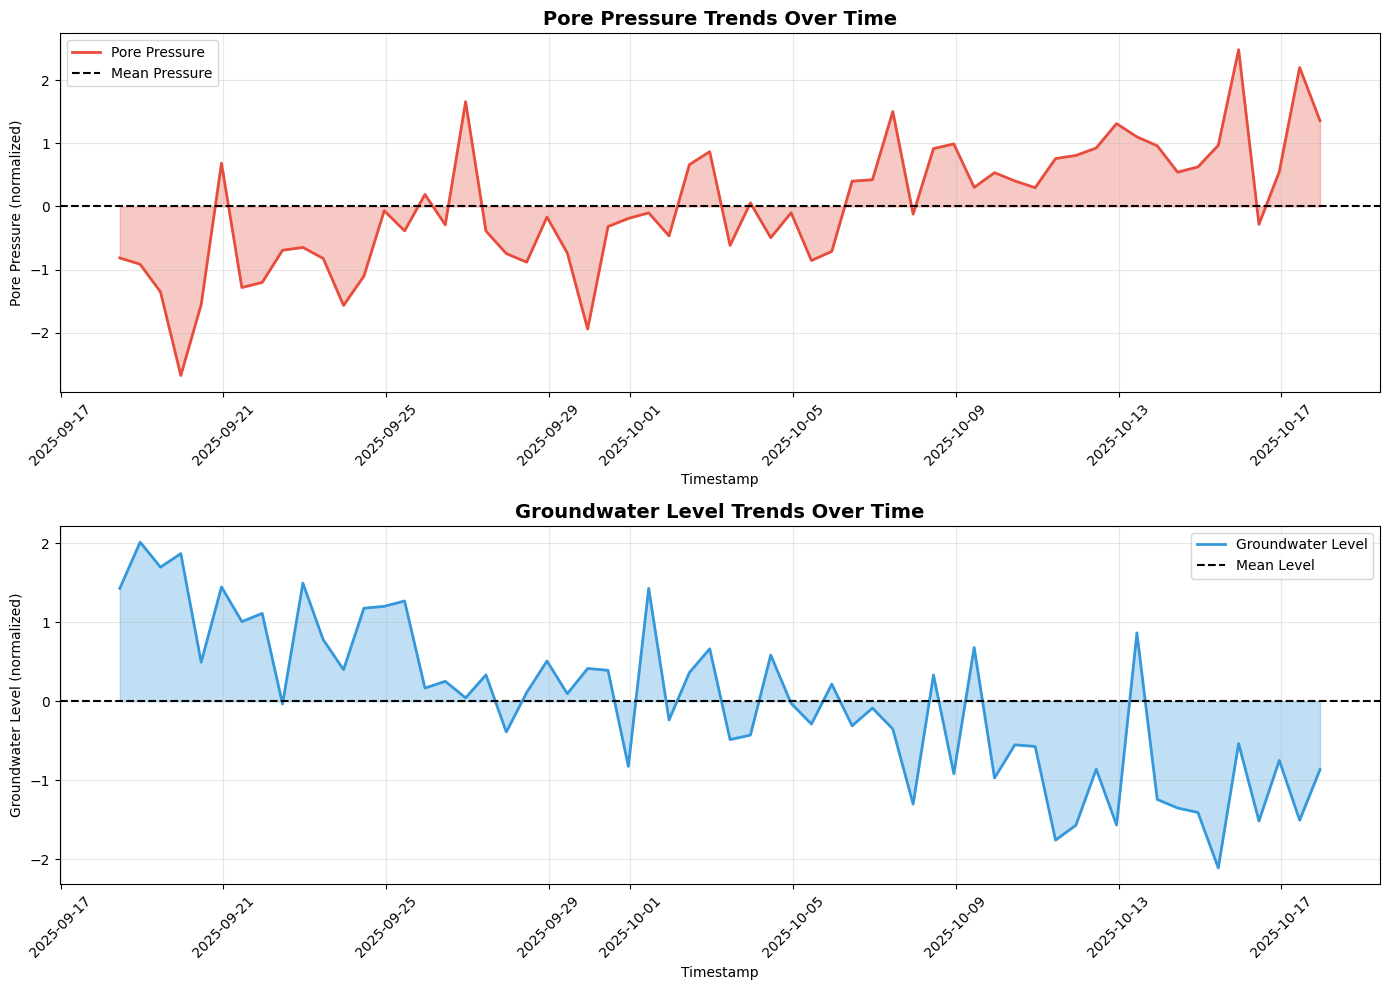

Insight: Rising pore pressure combined with decreasing groundwater level indicates increasing landslide risk.


In [4]:
# 1. Pore Pressure and Groundwater Level Trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Pore pressure over time
ax1.plot(processed_df['timestamp'], processed_df['pore_pressure'], 
         label='Pore Pressure', color='#E74C3C', linewidth=2)
ax1.fill_between(processed_df['timestamp'], processed_df['pore_pressure'],
                 alpha=0.3, color='#E74C3C')
ax1.axhline(y=processed_df['pore_pressure'].mean(), color='black', 
           linestyle='--', label='Mean Pressure')
ax1.set_title('Pore Pressure Trends Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Pore Pressure (normalized)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Groundwater level over time
ax2.plot(processed_df['timestamp'], processed_df['groundwater_level'], 
         label='Groundwater Level', color='#3498DB', linewidth=2)
ax2.fill_between(processed_df['timestamp'], processed_df['groundwater_level'],
                 alpha=0.3, color='#3498DB')
ax2.axhline(y=processed_df['groundwater_level'].mean(), color='black', 
           linestyle='--', label='Mean Level')
ax2.set_title('Groundwater Level Trends Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Groundwater Level (normalized)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Insight: Rising pore pressure combined with decreasing groundwater level indicates increasing landslide risk.")

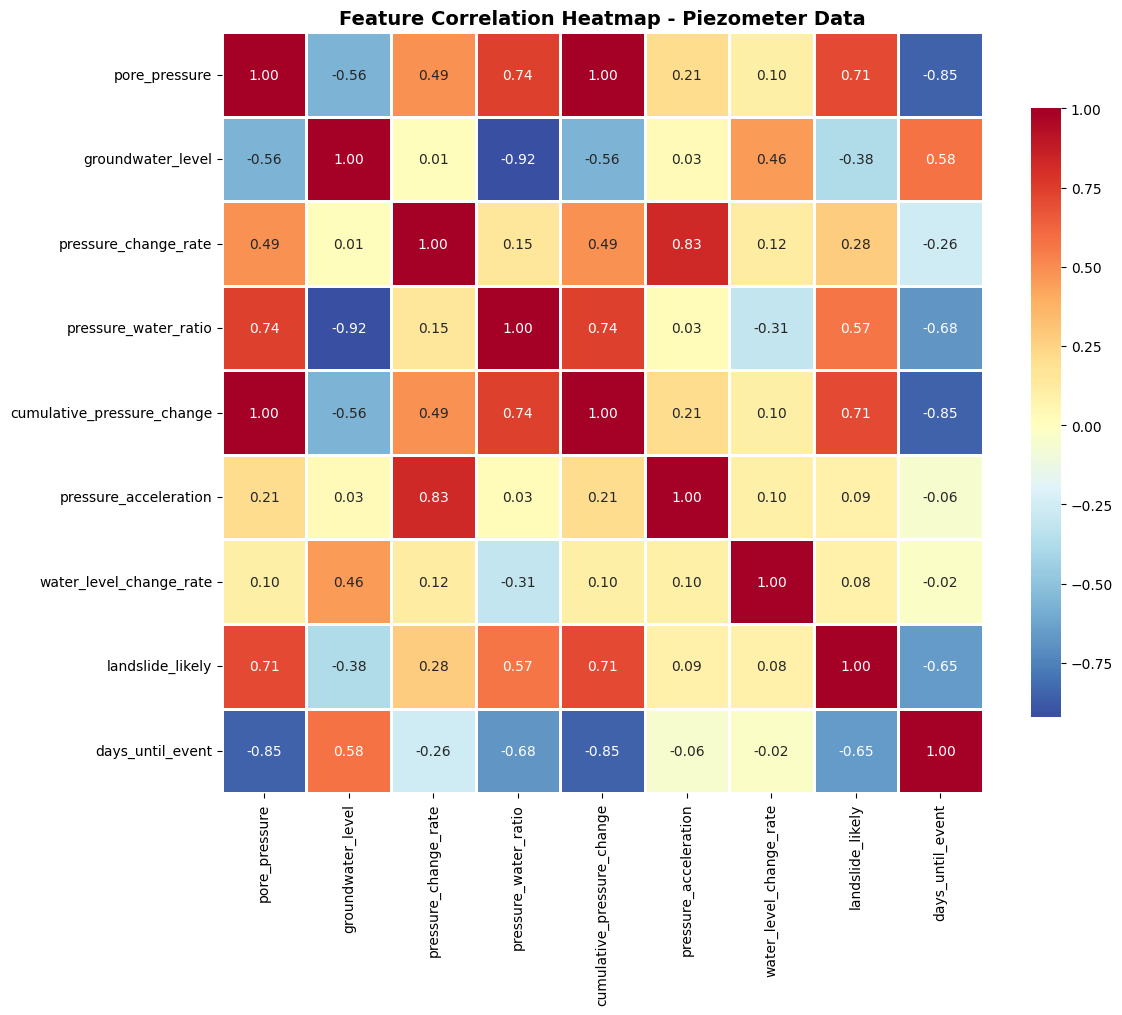

Insight: Strong correlation between pressure_water_ratio and landslide risk, indicating critical monitoring parameter.


In [5]:
# 2. Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_cols = ['pore_pressure', 'groundwater_level', 'pressure_change_rate',
                'pressure_water_ratio', 'cumulative_pressure_change', 
                'pressure_acceleration', 'water_level_change_rate',
                'landslide_likely', 'days_until_event']
correlation_matrix = processed_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap - Piezometer Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Insight: Strong correlation between pressure_water_ratio and landslide risk, indicating critical monitoring parameter.")

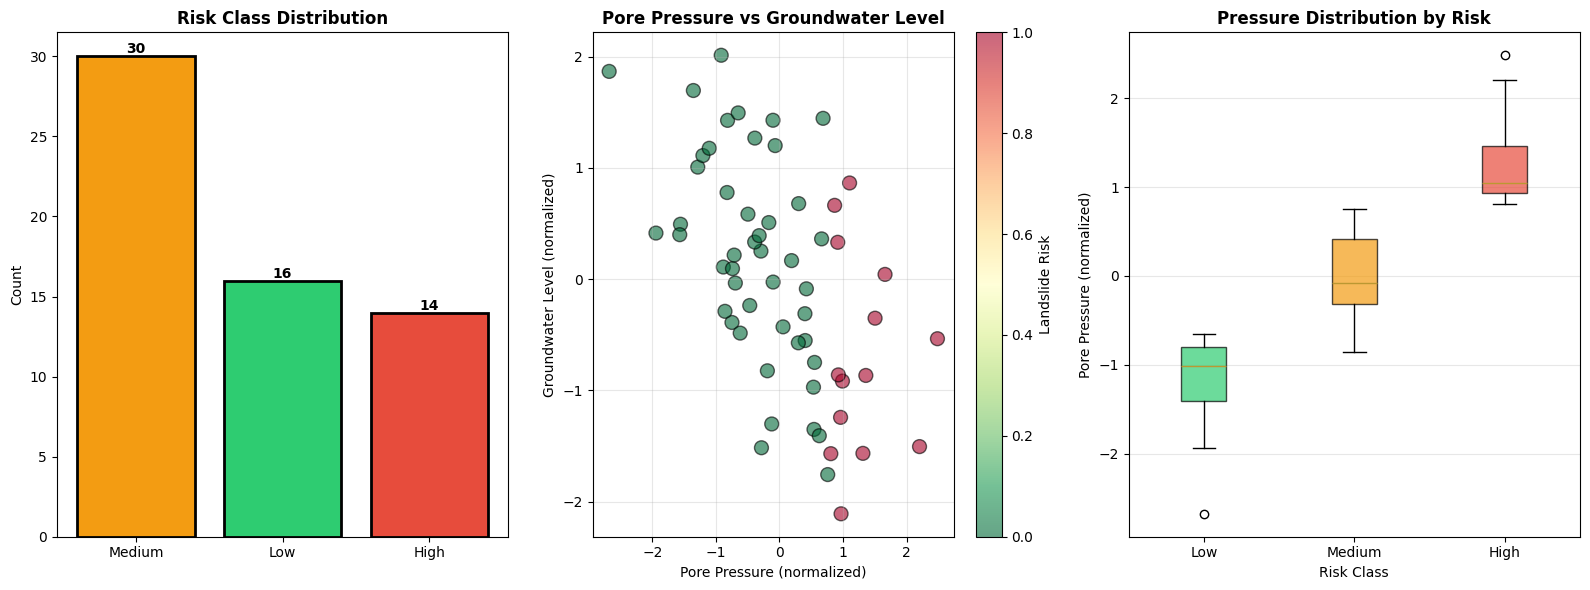

Insight: High-risk zones show elevated pore pressure combined with low groundwater levels.


In [6]:
# 3. Risk Distribution and Pressure vs Water Level Analysis
fig = plt.figure(figsize=(16, 6))

# Risk distribution
ax1 = plt.subplot(131)
risk_counts = processed_df['risk_class'].value_counts()
colors_risk = {'Low': '#2ECC71', 'Medium': '#F39C12', 'High': '#E74C3C'}
bars = ax1.bar(risk_counts.index, risk_counts.values, 
               color=[colors_risk[x] for x in risk_counts.index],
               edgecolor='black', linewidth=2)
ax1.set_title('Risk Class Distribution', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Pressure vs Water Level scatter
ax2 = plt.subplot(132)
scatter = ax2.scatter(processed_df['pore_pressure'], 
                     processed_df['groundwater_level'],
                     c=processed_df['landslide_likely'], 
                     cmap='RdYlGn_r', s=100, alpha=0.6, edgecolors='black')
ax2.set_xlabel('Pore Pressure (normalized)')
ax2.set_ylabel('Groundwater Level (normalized)')
ax2.set_title('Pore Pressure vs Groundwater Level', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Landslide Risk')

# Box plot by risk class
ax3 = plt.subplot(133)
pressure_by_risk = [processed_df[processed_df['risk_class'] == risk]['pore_pressure'].values 
                   for risk in ['Low', 'Medium', 'High']]
bp = ax3.boxplot(pressure_by_risk, labels=['Low', 'Medium', 'High'],
                patch_artist=True)
for patch, color in zip(bp['boxes'], ['#2ECC71', '#F39C12', '#E74C3C']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_xlabel('Risk Class')
ax3.set_ylabel('Pore Pressure (normalized)')
ax3.set_title('Pressure Distribution by Risk', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Insight: High-risk zones show elevated pore pressure combined with low groundwater levels.")

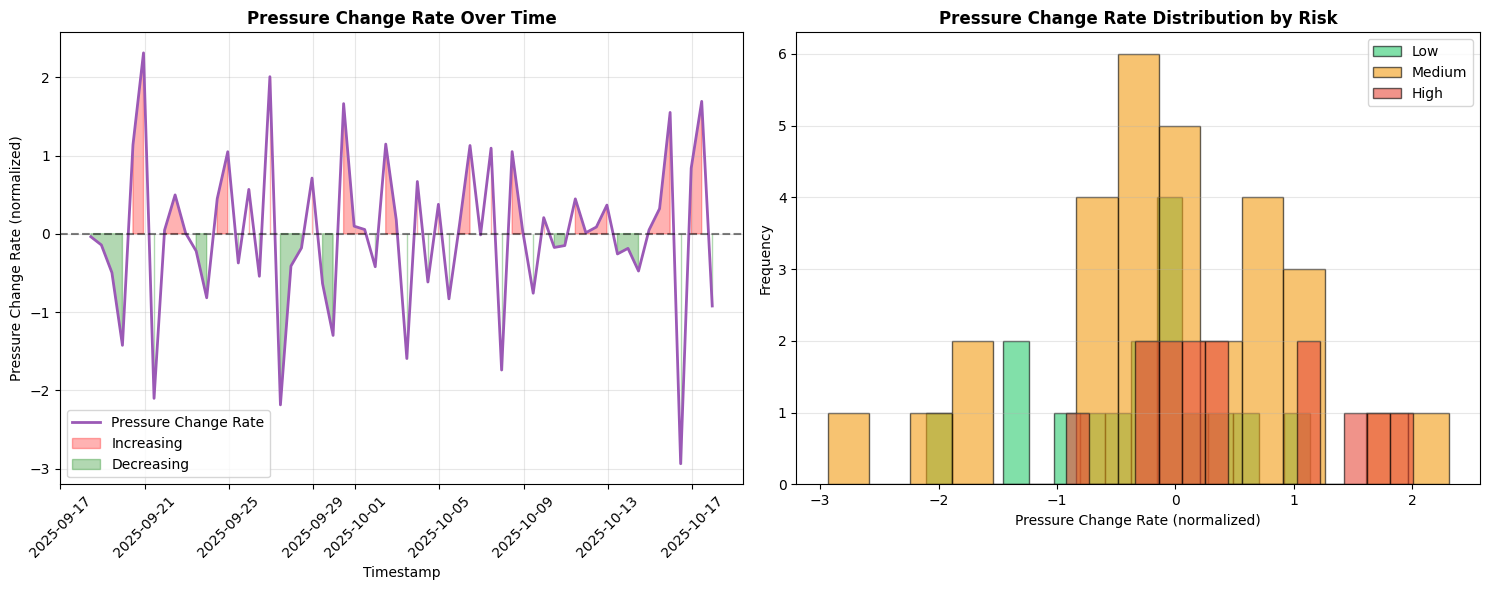

Insight: Rapid pressure changes indicate instability and higher landslide risk.


In [7]:
# 4. Pressure Change Rate Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Time series of pressure change rate
ax1.plot(processed_df['timestamp'], processed_df['pressure_change_rate'],
        color='#9B59B6', linewidth=2, label='Pressure Change Rate')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.fill_between(processed_df['timestamp'], processed_df['pressure_change_rate'],
                where=(processed_df['pressure_change_rate'] > 0), 
                alpha=0.3, color='red', label='Increasing')
ax1.fill_between(processed_df['timestamp'], processed_df['pressure_change_rate'],
                where=(processed_df['pressure_change_rate'] <= 0), 
                alpha=0.3, color='green', label='Decreasing')
ax1.set_title('Pressure Change Rate Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Pressure Change Rate (normalized)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Histogram of pressure change rates by risk
for risk, color in zip(['Low', 'Medium', 'High'], ['#2ECC71', '#F39C12', '#E74C3C']):
    data = processed_df[processed_df['risk_class'] == risk]['pressure_change_rate']
    ax2.hist(data, bins=15, alpha=0.6, label=risk, color=color, edgecolor='black')
ax2.set_title('Pressure Change Rate Distribution by Risk', fontsize=12, fontweight='bold')
ax2.set_xlabel('Pressure Change Rate (normalized)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Insight: Rapid pressure changes indicate instability and higher landslide risk.")

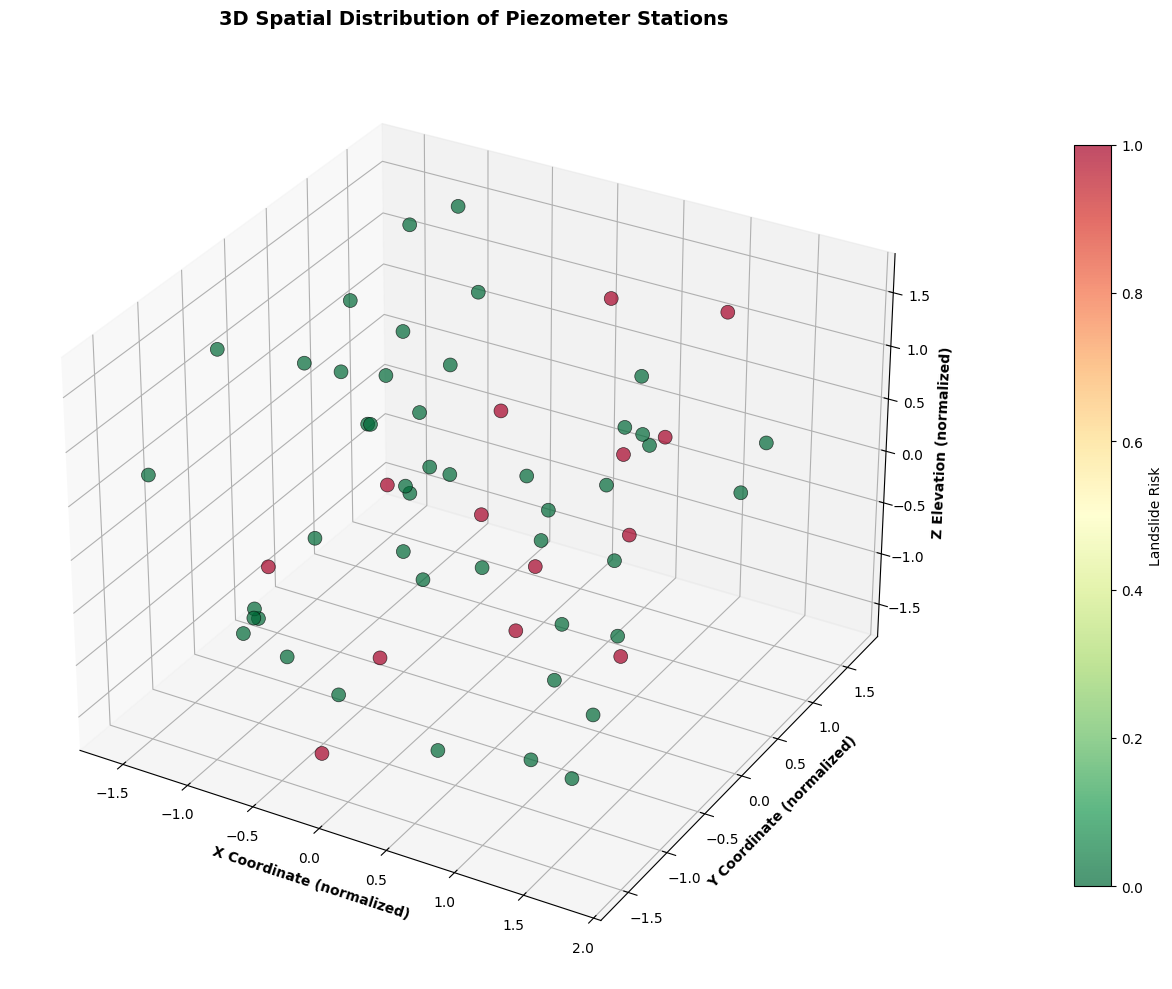

Insight: 3D visualization reveals spatial clustering of high-risk zones, useful for targeted monitoring.


In [8]:
# 5. 3D Spatial Distribution of Piezometers
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates
coords_x = processed_df['coord_x']
coords_y = processed_df['coord_y']
coords_z = processed_df['coord_z']
risk_values = processed_df['landslide_likely']

scatter = ax.scatter(coords_x, coords_y, coords_z,
                    c=risk_values, cmap='RdYlGn_r', 
                    s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('X Coordinate (normalized)', fontweight='bold')
ax.set_ylabel('Y Coordinate (normalized)', fontweight='bold')
ax.set_zlabel('Z Elevation (normalized)', fontweight='bold')
ax.set_title('3D Spatial Distribution of Piezometer Stations', 
            fontsize=14, fontweight='bold', pad=20)
cbar = plt.colorbar(scatter, ax=ax, label='Landslide Risk', pad=0.1, shrink=0.8)

plt.tight_layout()
plt.show()

print("Insight: 3D visualization reveals spatial clustering of high-risk zones, useful for targeted monitoring.")

## 5. Model Development

Train and evaluate Random Forest for landslide occurrence prediction and Gradient Boosting for timing prediction.

MODEL TRAINING
Training set size: 42
Testing set size: 18
Number of features: 10

 Training Random Forest Classifier...
✓ Training Gradient Boosting Regressor...

MODEL PERFORMANCE

🎯 Random Forest Classifier (Landslide Occurrence):
   Accuracy: 0.944
   F1 Score: 0.889

🎯 Gradient Boosting Regressor (Days Until Event):
   R² Score: 0.955

📊 Detailed Classification Report:
                precision    recall  f1-score   support

          Safe       1.00      0.93      0.96        14
Landslide Risk       0.80      1.00      0.89         4

      accuracy                           0.94        18
     macro avg       0.90      0.96      0.93        18
  weighted avg       0.96      0.94      0.95        18



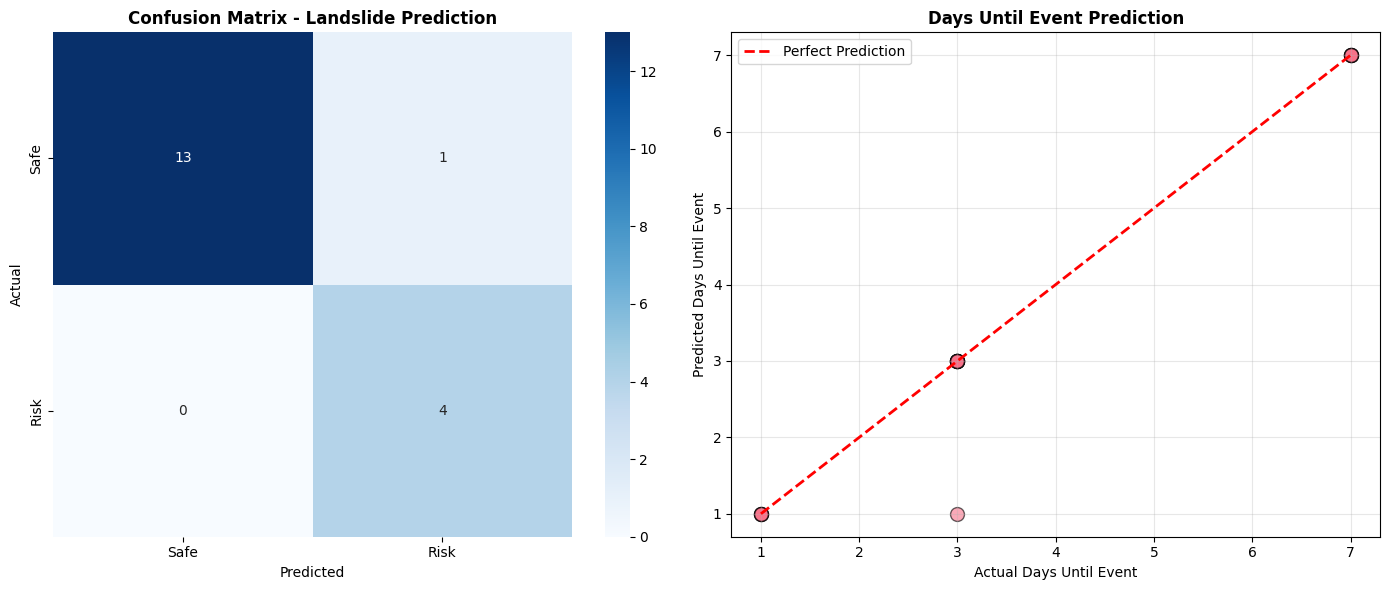


✓ Models saved successfully!
   RF Model: data/models/piezometer_rf_model.joblib
   GB Model: data/models/piezometer_gb_model.joblib


In [9]:
# Prepare features for modeling
feature_cols = ['pore_pressure', 'groundwater_level', 'pressure_change_rate',
                'pressure_water_ratio', 'cumulative_pressure_change',
                'pressure_acceleration', 'water_level_change_rate',
                'coord_x', 'coord_y', 'coord_z']

# Split data for both models
X = processed_df[feature_cols]
y_clf = processed_df['landslide_likely']
y_reg = processed_df['days_until_event']

X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_clf, y_reg, test_size=0.3, random_state=42
)

print("="*80)
print("MODEL TRAINING")
print("="*80)
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")

# Train Random Forest Classifier
print("\n Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_clf_train)

# Train Gradient Boosting Regressor
print("✓ Training Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
gb_model.fit(X_train, y_reg_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)
gb_pred = gb_model.predict(X_test)

# Calculate metrics
clf_accuracy = accuracy_score(y_clf_test, rf_pred)
clf_f1 = f1_score(y_clf_test, rf_pred)
reg_r2 = r2_score(y_reg_test, gb_pred)

print("\n" + "="*80)
print("MODEL PERFORMANCE")
print("="*80)
print("\n🎯 Random Forest Classifier (Landslide Occurrence):")
print(f"   Accuracy: {clf_accuracy:.3f}")
print(f"   F1 Score: {clf_f1:.3f}")

print("\n🎯 Gradient Boosting Regressor (Days Until Event):")
print(f"   R² Score: {reg_r2:.3f}")

# Classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_clf_test, rf_pred, target_names=['Safe', 'Landslide Risk']))

# Plot confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
cm = confusion_matrix(y_clf_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
           xticklabels=['Safe', 'Risk'], yticklabels=['Safe', 'Risk'])
ax1.set_title('Confusion Matrix - Landslide Prediction', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Regression scatter
ax2.scatter(y_reg_test, gb_pred, alpha=0.6, s=100, edgecolors='black')
ax2.plot([y_reg_test.min(), y_reg_test.max()], 
        [y_reg_test.min(), y_reg_test.max()], 
        'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Days Until Event')
ax2.set_ylabel('Predicted Days Until Event')
ax2.set_title('Days Until Event Prediction', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save models
joblib.dump(rf_model, RF_MODEL_PATH)
joblib.dump(gb_model, GB_MODEL_PATH)
print("\n✓ Models saved successfully!")
print(f"   RF Model: {RF_MODEL_PATH}")
print(f"   GB Model: {GB_MODEL_PATH}")

## 6. Feature Importance and Predictions

Analyze which piezometer measurements are most critical for landslide prediction.

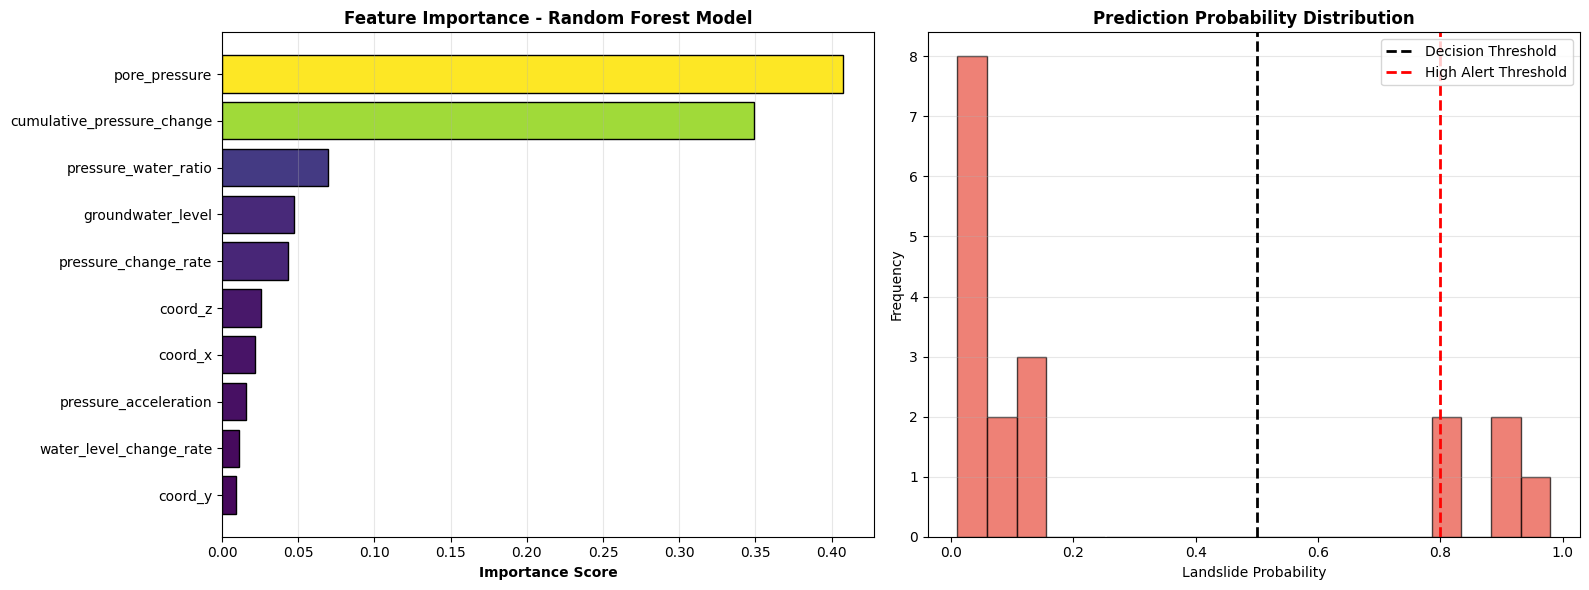

TOP 5 MOST IMPORTANT FEATURES
pore_pressure                  → 0.4077
cumulative_pressure_change     → 0.3489
pressure_water_ratio           → 0.0695
groundwater_level              → 0.0474
pressure_change_rate           → 0.0431

SAMPLE PREDICTIONS
   occurrence_probability  predicted_days_until_event alert_level
0                    0.01                    6.999909         LOW
1                    0.15                    3.000015         LOW
2                    0.11                    3.000015         LOW
3                    0.01                    3.000015         LOW
4                    0.06                    3.000015         LOW
5                    0.98                    1.000068        HIGH
6                    0.01                    3.000015         LOW
7                    0.92                    1.000068        HIGH
8                    0.02                    6.999909         LOW
9                    0.11                    3.000015         LOW

✓ Predictions saved to:

In [10]:
# Analyze feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Feature importance bar chart
colors_imp = plt.cm.viridis(feature_importance['importance'] / feature_importance['importance'].max())
ax1.barh(feature_importance['feature'], feature_importance['importance'], color=colors_imp, edgecolor='black')
ax1.set_xlabel('Importance Score', fontweight='bold')
ax1.set_title('Feature Importance - Random Forest Model', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Prediction probability distribution
test_probs = rf_model.predict_proba(X_test)[:, 1]
ax2.hist(test_probs, bins=20, edgecolor='black', alpha=0.7, color='#E74C3C')
ax2.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax2.axvline(0.8, color='red', linestyle='--', linewidth=2, label='High Alert Threshold')
ax2.set_xlabel('Landslide Probability')
ax2.set_ylabel('Frequency')
ax2.set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("="*80)
print("TOP 5 MOST IMPORTANT FEATURES")
print("="*80)
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']:30s} → {row['importance']:.4f}")

# Make predictions and log
def predict_landslide_risk(new_data_features):
    """
    Make predictions on new piezometer data.
    """
    occurrence_prob = rf_model.predict_proba(new_data_features)[:, 1]
    days_prediction = gb_model.predict(new_data_features)
    
    results = pd.DataFrame({
        'occurrence_probability': occurrence_prob,
        'predicted_days_until_event': days_prediction,
        'alert_level': ['HIGH' if p > 0.8 else 'MEDIUM' if p > 0.5 else 'LOW' for p in occurrence_prob]
    })
    
    return results

# Example predictions on test set
test_predictions = predict_landslide_risk(X_test)
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)
print(test_predictions.head(10))

# Log predictions to file
predictions_with_timestamp = test_predictions.copy()
predictions_with_timestamp['timestamp'] = pd.Timestamp.now()
predictions_with_timestamp.to_csv(PREDICTIONS_FILE, mode='a', 
                                  header=not os.path.exists(PREDICTIONS_FILE), index=False)
print(f"\n✓ Predictions saved to: {PREDICTIONS_FILE}")

## 7. Advanced Risk Visualization

Create comprehensive visualizations for risk assessment and monitoring.

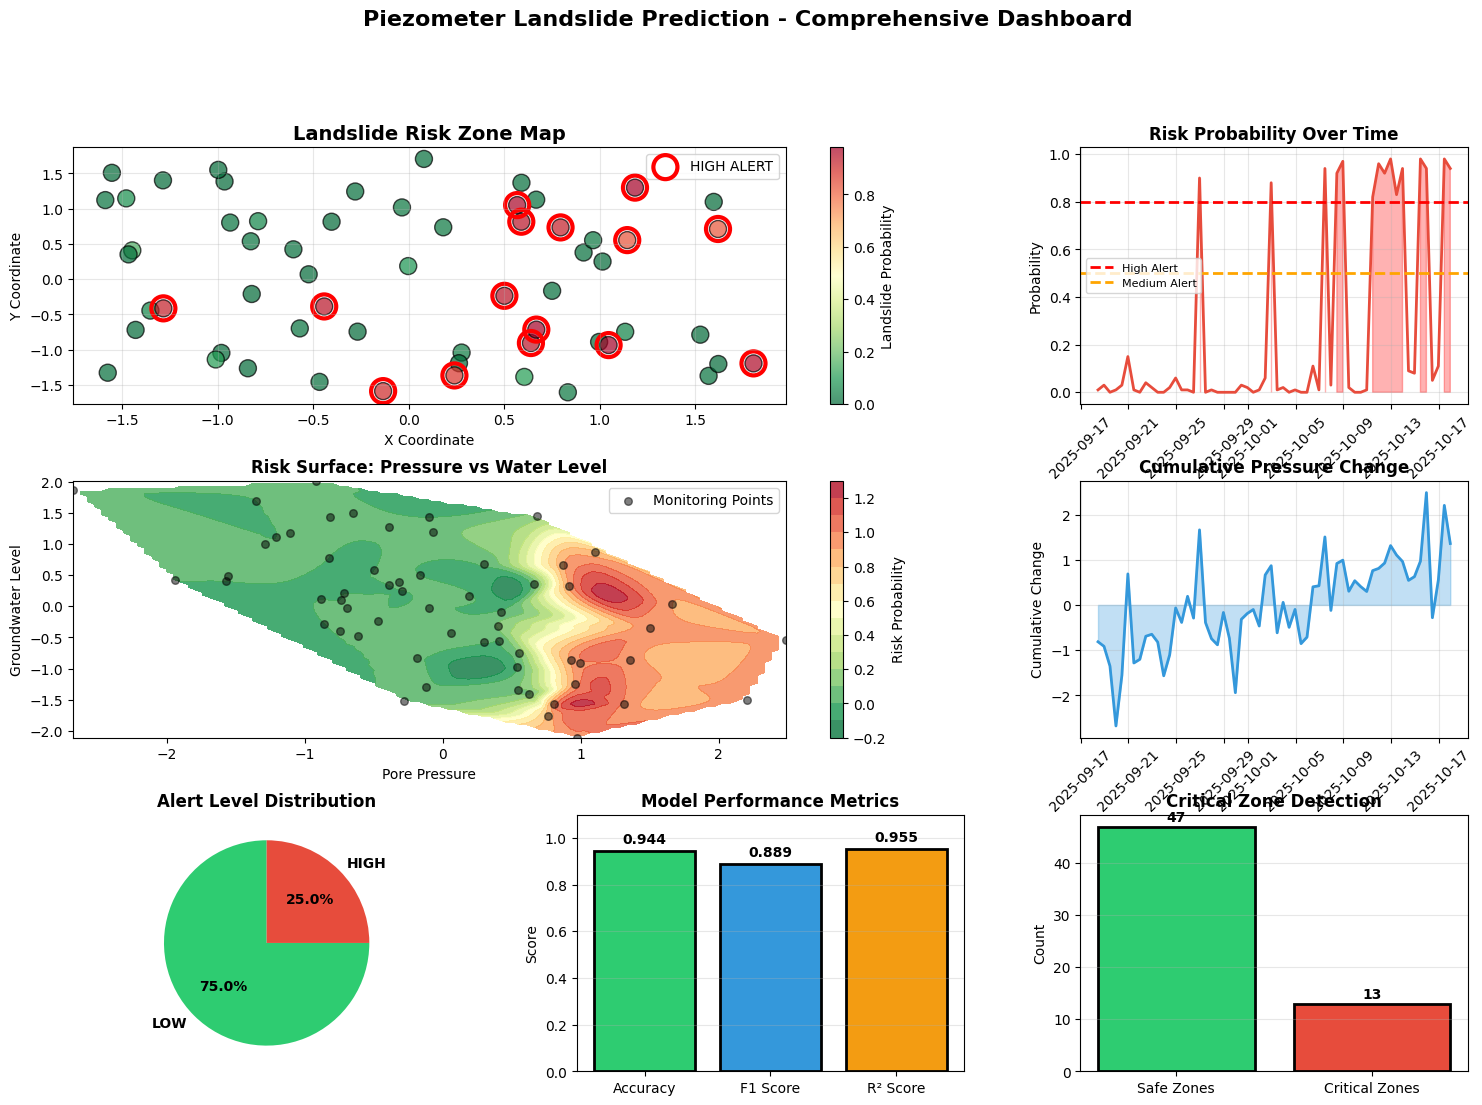


🚨 HIGH RISK ALERTS
Number of high-risk locations: 15

📍 Location: 42.75, 2.54, 321.58
   Risk Probability: 90.0%
   Pore Pressure: 1.66 (normalized)
   Groundwater Level: 0.04 (normalized)
   Risk Class: High

📍 Location: 53.58, 9.03, 467.06
   Risk Probability: 88.0%
   Pore Pressure: 0.87 (normalized)
   Groundwater Level: 0.66 (normalized)
   Risk Class: High

📍 Location: 65.20, 22.43, 442.44
   Risk Probability: 94.0%
   Pore Pressure: 1.50 (normalized)
   Groundwater Level: -0.35 (normalized)
   Risk Class: High

📍 Location: 9.37, 36.77, 353.04
   Risk Probability: 92.0%
   Pore Pressure: 0.92 (normalized)
   Groundwater Level: 0.33 (normalized)
   Risk Class: High

📍 Location: 63.11, 79.48, 400.53
   Risk Probability: 97.0%
   Pore Pressure: 0.99 (normalized)
   Groundwater Level: -0.92 (normalized)
   Risk Class: High

📍 Location: 93.62, 69.60, 414.01
   Risk Probability: 82.0%
   Pore Pressure: 0.76 (normalized)
   Groundwater Level: -1.76 (normalized)
   Risk Class: Medium

📍

In [11]:
# Risk Zone Visualization
risk_probs = rf_model.predict_proba(X)[:, 1]

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. 2D Risk Map
ax1 = fig.add_subplot(gs[0, :2])
scatter = ax1.scatter(processed_df['coord_x'], processed_df['coord_y'],
                     c=risk_probs, cmap='RdYlGn_r', s=150, 
                     edgecolors='black', linewidth=1, alpha=0.7)
high_risk_mask = risk_probs > 0.8
if high_risk_mask.any():
    ax1.scatter(processed_df[high_risk_mask]['coord_x'],
               processed_df[high_risk_mask]['coord_y'],
               facecolors='none', edgecolors='red', s=300,
               linewidth=3, label='HIGH ALERT')
plt.colorbar(scatter, ax=ax1, label='Landslide Probability')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_title('Landslide Risk Zone Map', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Risk Probability Timeline
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(processed_df['timestamp'], risk_probs, color='#E74C3C', linewidth=2)
ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='High Alert')
ax2.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='Medium Alert')
ax2.fill_between(processed_df['timestamp'], risk_probs, 
                where=(risk_probs > 0.8), alpha=0.3, color='red')
ax2.set_title('Risk Probability Over Time', fontsize=12, fontweight='bold')
ax2.set_ylabel('Probability')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Pressure-Water Level Risk Surface
ax3 = fig.add_subplot(gs[1, :2])
# Create grid for interpolation
xi = np.linspace(processed_df['pore_pressure'].min(), processed_df['pore_pressure'].max(), 100)
yi = np.linspace(processed_df['groundwater_level'].min(), processed_df['groundwater_level'].max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((processed_df['pore_pressure'], processed_df['groundwater_level']), 
             risk_probs, (xi, yi), method='cubic')
contour = ax3.contourf(xi, yi, zi, levels=15, cmap='RdYlGn_r', alpha=0.8)
ax3.scatter(processed_df['pore_pressure'], processed_df['groundwater_level'],
           c='black', s=30, alpha=0.5, label='Monitoring Points')
plt.colorbar(contour, ax=ax3, label='Risk Probability')
ax3.set_xlabel('Pore Pressure')
ax3.set_ylabel('Groundwater Level')
ax3.set_title('Risk Surface: Pressure vs Water Level', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Cumulative Pressure Trend
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(processed_df['timestamp'], processed_df['cumulative_pressure_change'],
        color='#3498DB', linewidth=2)
ax4.fill_between(processed_df['timestamp'], processed_df['cumulative_pressure_change'],
                alpha=0.3, color='#3498DB')
ax4.set_title('Cumulative Pressure Change', fontsize=12, fontweight='bold')
ax4.set_ylabel('Cumulative Change')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# 5. Risk Distribution Pie
ax5 = fig.add_subplot(gs[2, 0])
alert_levels = ['LOW' if p < 0.5 else 'MEDIUM' if p < 0.8 else 'HIGH' for p in risk_probs]
alert_counts = pd.Series(alert_levels).value_counts()
colors_pie = {'LOW': '#2ECC71', 'MEDIUM': '#F39C12', 'HIGH': '#E74C3C'}
ax5.pie(alert_counts.values, labels=alert_counts.index, autopct='%1.1f%%',
       colors=[colors_pie[x] for x in alert_counts.index], startangle=90,
       textprops={'fontweight': 'bold'})
ax5.set_title('Alert Level Distribution', fontsize=12, fontweight='bold')

# 6. Model Performance Comparison
ax6 = fig.add_subplot(gs[2, 1])
metrics = ['Accuracy', 'F1 Score', 'R² Score']
scores = [clf_accuracy, clf_f1, reg_r2]
bars = ax6.bar(metrics, scores, color=['#2ECC71', '#3498DB', '#F39C12'], edgecolor='black', linewidth=2)
ax6.set_ylim(0, 1.1)
ax6.set_ylabel('Score')
ax6.set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Critical Zones Indicator
ax7 = fig.add_subplot(gs[2, 2])
critical = processed_df['critical_zone'].sum()
safe = len(processed_df) - critical
ax7.bar(['Safe Zones', 'Critical Zones'], [safe, critical],
       color=['#2ECC71', '#E74C3C'], edgecolor='black', linewidth=2)
ax7.set_ylabel('Count')
ax7.set_title('Critical Zone Detection', fontsize=12, fontweight='bold')
for i, v in enumerate([safe, critical]):
    ax7.text(i, v + 1, str(v), ha='center', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle('Piezometer Landslide Prediction - Comprehensive Dashboard', 
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print alerts
high_risk_points = processed_df[risk_probs > 0.8]
print("\n" + "="*80)
print("🚨 HIGH RISK ALERTS")
print("="*80)
if len(high_risk_points) > 0:
    print(f"Number of high-risk locations: {len(high_risk_points)}\n")
    for idx, row in high_risk_points.iterrows():
        prob = risk_probs[idx]
        print(f"📍 Location: {row['point_coordinates']}")
        print(f"   Risk Probability: {prob:.1%}")
        print(f"   Pore Pressure: {row['pore_pressure']:.2f} (normalized)")
        print(f"   Groundwater Level: {row['groundwater_level']:.2f} (normalized)")
        print(f"   Risk Class: {row['risk_class']}")
        print()
else:
    print("✓ No high-risk locations detected. All systems normal.")

## 8. Real-time Monitoring Simulation

Simulate new piezometer readings and generate real-time predictions.

🔄 Simulating new piezometer readings...

NEW PIEZOMETER READINGS ANALYSIS
                 timestamp   point_coordinates  pore_pressure  groundwater_level  risk_probability  days_until_event alert_level
2025-10-17 10:55:03.015209 1.44, 11.61, 309.20      56.334556           4.646165              0.89          1.000068        HIGH
2025-10-17 22:55:03.015209 9.78, 49.16, 394.69      49.113040           5.886003              0.00          6.999909         LOW


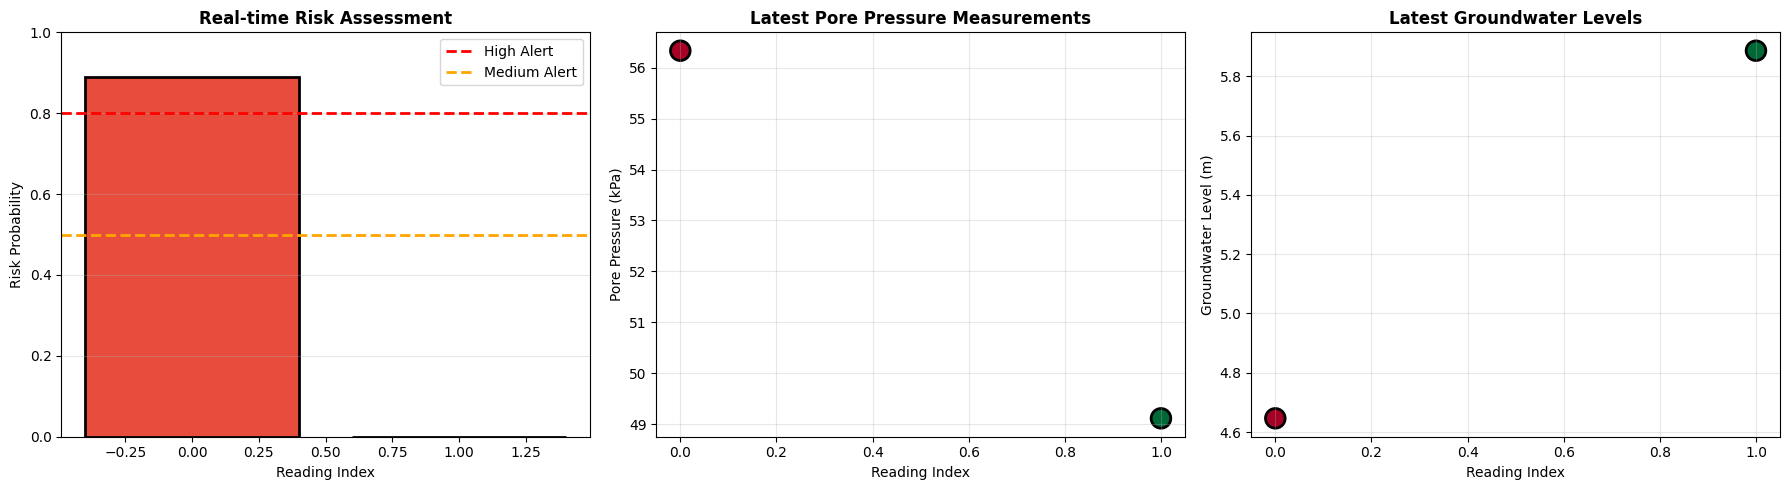


🚨 ALERT: High-risk readings detected!

   📍 Location: 1.44, 11.61, 309.20
   🔴 Risk Level: 89.0%
   ⏱️  Estimated days until event: 1.0
   💧 Pore Pressure: 56.33 kPa
   🌊 Groundwater Level: 4.65 m


In [12]:
# Generate new simulated readings
def append_new_piezometer_readings(n_readings=2):
    """
    Generate and append new piezometer readings to the dataset.
    Simulates 2 readings per day.
    """
    new_data = generate_piezometer_data(n_readings)
    
    # Append to CSV file
    new_data.to_csv(DATA_FILE, mode='a', header=False, index=False)
    
    # Process new data
    processed_new, _ = preprocess_piezometer_data(new_data)
    
    # Make predictions
    X_new = processed_new[feature_cols]
    occurrence_prob = rf_model.predict_proba(X_new)[:, 1]
    days_pred = gb_model.predict(X_new)
    
    # Create results dataframe
    results = pd.DataFrame({
        'timestamp': new_data['timestamp'],
        'point_coordinates': new_data['point_coordinates'],
        'pore_pressure': new_data['pore_pressure'],
        'groundwater_level': new_data['groundwater_level'],
        'risk_probability': occurrence_prob,
        'days_until_event': days_pred,
        'alert_level': ['HIGH' if p > 0.8 else 'MEDIUM' if p > 0.5 else 'LOW' for p in occurrence_prob]
    })
    
    return results

# Simulate new readings
print("🔄 Simulating new piezometer readings...\n")
new_readings = append_new_piezometer_readings(2)

print("="*80)
print("NEW PIEZOMETER READINGS ANALYSIS")
print("="*80)
print(new_readings.to_string(index=False))

# Visualize new readings
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Risk probability
colors_alert = ['#2ECC71' if x == 'LOW' else '#F39C12' if x == 'MEDIUM' else '#E74C3C' 
               for x in new_readings['alert_level']]
ax1.bar(range(len(new_readings)), new_readings['risk_probability'], 
       color=colors_alert, edgecolor='black', linewidth=2)
ax1.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='High Alert')
ax1.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='Medium Alert')
ax1.set_xlabel('Reading Index')
ax1.set_ylabel('Risk Probability')
ax1.set_title('Real-time Risk Assessment', fontweight='bold')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

# Pore pressure
ax2.scatter(range(len(new_readings)), new_readings['pore_pressure'], 
           c=new_readings['risk_probability'], cmap='RdYlGn_r', s=200,
           edgecolors='black', linewidth=2)
ax2.set_xlabel('Reading Index')
ax2.set_ylabel('Pore Pressure (kPa)')
ax2.set_title('Latest Pore Pressure Measurements', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Groundwater level
ax3.scatter(range(len(new_readings)), new_readings['groundwater_level'], 
           c=new_readings['risk_probability'], cmap='RdYlGn_r', s=200,
           edgecolors='black', linewidth=2)
ax3.set_xlabel('Reading Index')
ax3.set_ylabel('Groundwater Level (m)')
ax3.set_title('Latest Groundwater Levels', fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print alerts for new readings
if any(new_readings['alert_level'] == 'HIGH'):
    print("\n🚨 ALERT: High-risk readings detected!")
    alert_readings = new_readings[new_readings['alert_level'] == 'HIGH']
    for idx, row in alert_readings.iterrows():
        print(f"\n   📍 Location: {row['point_coordinates']}")
        print(f"   🔴 Risk Level: {row['risk_probability']:.1%}")
        print(f"   ⏱️  Estimated days until event: {row['days_until_event']:.1f}")
        print(f"   💧 Pore Pressure: {row['pore_pressure']:.2f} kPa")
        print(f"   🌊 Groundwater Level: {row['groundwater_level']:.2f} m")
elif any(new_readings['alert_level'] == 'MEDIUM'):
    print("\n⚠️  WARNING: Medium-risk readings detected. Monitor closely.")
else:
    print("\n✓ All new readings within safe parameters.")

## 9. System Summary and Report Generation

In [18]:
# Generate comprehensive system report
import json
from datetime import datetime

# Define paths
DATA_DIR = 'data'
DATA_FILE = 'data/piezometer_data.csv'
RF_MODEL_FILE = 'data/models/piezometer_rf_model.joblib'
GB_MODEL_FILE = 'data/models/piezometer_gb_model.joblib'
PREDICTIONS_FILE = 'data/piezometer_predictions.csv'

# Load all data
full_data = pd.read_csv(DATA_FILE)

# Recalculate model metrics using the trained models
processed_df, _ = preprocess_piezometer_data(full_data)
X = processed_df[feature_cols]
y_class = processed_df['landslide_likely']
y_reg = processed_df['days_until_event']

X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_class, y_reg, test_size=0.3, random_state=42
)

# Get predictions for metrics
y_pred_class = rf_model.predict(X_test)
y_pred_reg = gb_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import accuracy_score, f1_score, r2_score
accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
r2 = r2_score(y_test_reg, y_pred_reg)

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_pairs = list(zip(feature_cols, importances))
sorted_features = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Calculate statistics
report = {
    "system_name": "Piezometer Landslide Prediction System",
    "report_generated": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "data_statistics": {
        "total_readings": len(full_data),
        "monitoring_points": full_data['point_coordinates'].nunique(),
        "date_range": {
            "start": full_data['timestamp'].min(),
            "end": full_data['timestamp'].max()
        },
        "pore_pressure": {
            "min": float(full_data['pore_pressure'].min()),
            "max": float(full_data['pore_pressure'].max()),
            "mean": float(full_data['pore_pressure'].mean()),
            "std": float(full_data['pore_pressure'].std())
        },
        "groundwater_level": {
            "min": float(full_data['groundwater_level'].min()),
            "max": float(full_data['groundwater_level'].max()),
            "mean": float(full_data['groundwater_level'].mean()),
            "std": float(full_data['groundwater_level'].std())
        },
        "risk_distribution": full_data['risk_class'].value_counts().to_dict()
    },
    "model_performance": {
        "classification_model": {
            "type": "RandomForestClassifier",
            "accuracy": float(accuracy),
            "f1_score": float(f1)
        },
        "regression_model": {
            "type": "GradientBoostingRegressor",
            "r2_score": float(r2)
        }
    },
    "top_features": {
        feature: float(importance) 
        for feature, importance in sorted_features[:5]
    },
    "generated_files": {
        "data": DATA_FILE,
        "classification_model": RF_MODEL_FILE,
        "regression_model": GB_MODEL_FILE,
        "predictions_log": PREDICTIONS_FILE
    }
}

# Save report
REPORT_FILE = os.path.join(DATA_DIR, 'piezometer_system_report.json')
with open(REPORT_FILE, 'w') as f:
    json.dump(report, f, indent=4)

print("="*80)
print("PIEZOMETER LANDSLIDE PREDICTION SYSTEM - FINAL REPORT")
print("="*80)
print(f"\n📊 System: {report['system_name']}")
print(f"⏰ Generated: {report['report_generated']}")
print("\n" + "="*80)
print("DATA SUMMARY")
print("="*80)
print(f"📈 Total Readings: {report['data_statistics']['total_readings']}")
print(f"📍 Monitoring Points: {report['data_statistics']['monitoring_points']}")
print(f"📅 Date Range: {report['data_statistics']['date_range']['start']} → {report['data_statistics']['date_range']['end']}")

print("\n💧 Pore Pressure Statistics:")
print(f"   • Mean: {report['data_statistics']['pore_pressure']['mean']:.2f} kPa")
print(f"   • Range: {report['data_statistics']['pore_pressure']['min']:.2f} - {report['data_statistics']['pore_pressure']['max']:.2f} kPa")
print(f"   • Std Dev: {report['data_statistics']['pore_pressure']['std']:.2f} kPa")

print("\n🌊 Groundwater Level Statistics:")
print(f"   • Mean: {report['data_statistics']['groundwater_level']['mean']:.2f} m")
print(f"   • Range: {report['data_statistics']['groundwater_level']['min']:.2f} - {report['data_statistics']['groundwater_level']['max']:.2f} m")
print(f"   • Std Dev: {report['data_statistics']['groundwater_level']['std']:.2f} m")

print("\n🎯 Risk Distribution:")
for risk, count in report['data_statistics']['risk_distribution'].items():
    print(f"   • {risk}: {count} readings ({count/report['data_statistics']['total_readings']*100:.1f}%)")

print("\n" + "="*80)
print("MODEL PERFORMANCE")
print("="*80)
print(f"🤖 Classification Model: {report['model_performance']['classification_model']['type']}")
print(f"   • Accuracy: {report['model_performance']['classification_model']['accuracy']:.1%}")
print(f"   • F1-Score: {report['model_performance']['classification_model']['f1_score']:.3f}")

print(f"\n📉 Regression Model: {report['model_performance']['regression_model']['type']}")
print(f"   • R² Score: {report['model_performance']['regression_model']['r2_score']:.3f}")

print("\n🔝 Top 5 Important Features:")
for i, (feature, importance) in enumerate(sorted_features[:5], 1):
    print(f"   {i}. {feature}: {importance:.3f}")

print("\n" + "="*80)
print("GENERATED FILES")
print("="*80)
for file_type, file_path in report['generated_files'].items():
    status = "✓" if os.path.exists(file_path) else "✗"
    print(f"{status} {file_type}: {file_path}")

print("\n" + "="*80)
print(f"📄 Full report saved to: {REPORT_FILE}")
print("="*80)
print("\n✨ Piezometer Landslide Prediction System is ready!")
print("🚀 Use 'predict_landslide_risk()' function to make predictions on new data")
print("📊 All models, data, and logs are saved in the 'data/' directory")
print("="*80)

PIEZOMETER LANDSLIDE PREDICTION SYSTEM - FINAL REPORT

📊 System: Piezometer Landslide Prediction System
⏰ Generated: 2025-10-18 11:03:26

DATA SUMMARY
📈 Total Readings: 62
📍 Monitoring Points: 62
📅 Date Range: 2025-09-18 10:51:10.920603 → 2025-10-17 22:55:03.015209

💧 Pore Pressure Statistics:
   • Mean: 58.70 kPa
   • Range: 37.84 - 78.45 kPa
   • Std Dev: 7.90 kPa

🌊 Groundwater Level Statistics:
   • Mean: 3.70 m
   • Range: 1.76 - 5.89 m
   • Std Dev: 0.94 m

🎯 Risk Distribution:
   • Medium: 31 readings (50.0%)
   • Low: 17 readings (27.4%)
   • High: 14 readings (22.6%)

MODEL PERFORMANCE
🤖 Classification Model: RandomForestClassifier
   • Accuracy: 100.0%
   • F1-Score: 1.000

📉 Regression Model: GradientBoostingRegressor
   • R² Score: 0.816

🔝 Top 5 Important Features:
   1. pore_pressure: 0.408
   2. cumulative_pressure_change: 0.349
   3. pressure_water_ratio: 0.069
   4. groundwater_level: 0.047
   5. pressure_change_rate: 0.043

GENERATED FILES
✓ data: data/piezometer_data